In [21]:
import os
import pickle
import warnings
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import soundfile as sf

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [7]:
audio = 'G:/My Drive/Contenido/apresionradio/apresionradio_analysis/data_extract/data_extract/audio/audio.wav'
wavdata,_ = librosa.load(audio)

In [11]:
segLen,frameRate,numMix = 3,50,128
mfcc = librosa.feature.mfcc(wavdata, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
#vad = np.reshape(numMix,1,)
#if mfcc.shape[0] > vad.shape[0]:
#    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
#elif mfcc.shape[0] < vad.shape[0]:
#    vad = vad[:mfcc.shape[0]]
#    mfcc = mfcc[vad,:];



Text(0.5, 0, 'GMM n_components for an audio file')

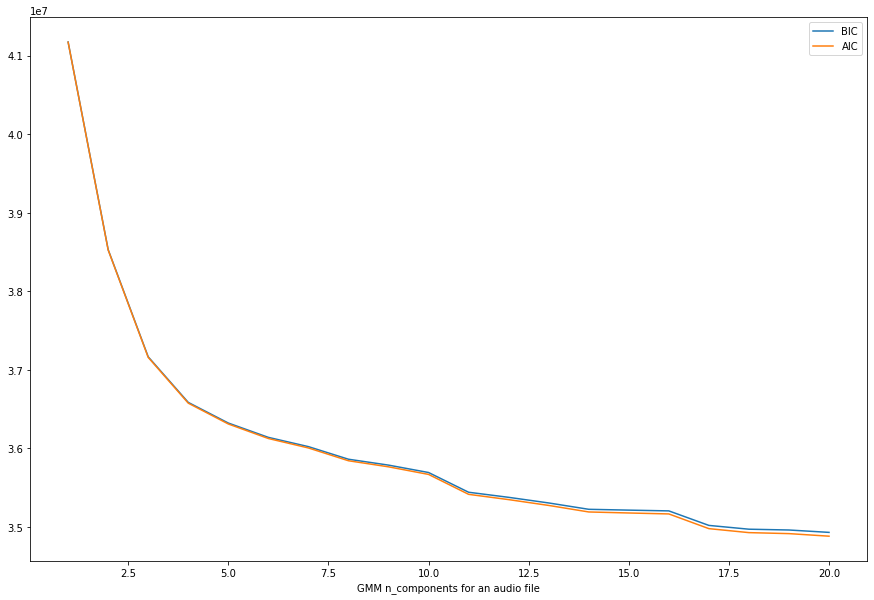

In [12]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file')

In [18]:
def trainGMM(wavFile, frameRate, segLen, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T

    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")
    return np.asarray(segLikes)
clusterset = trainGMM(audio, frameRate, segLen,  20)

Training GMM..
Training Done


In [48]:
scaler = StandardScaler()
# Scaling the data so that all the features become comparable
X_scaled = scaler.fit_transform(clusterset)
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
#X_normalized = normalize(X_scaled)
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_scaled)

In [49]:

def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])

In [50]:
vad = VoiceActivityDetection(wavdata,frameRate)
vad.shape

(264999, 1)

In [51]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal
  
pass1hyp = -1*np.ones(len(vad))
pass1hyp = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, audio)

In [58]:
spkdf.to_excel('audio_speakers.xlsx')

In [59]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

In [60]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

Downloading: 100%|██████████| 99.4M/99.4M [00:07<00:00, 12.9MB/s]
Downloading: 100%|██████████| 43.2M/43.2M [00:03<00:00, 12.2MB/s]


In [61]:
audio = 'G:/My Drive/Contenido/apresionradio/apresionradio_analysis/data_extract/data_extract/audio/audio.wav'
y, sr = malaya_speech.load(audio)
len(y), sr

(61532480, 16000)

In [68]:
y.shape

(61532480,)

In [70]:
y = y[:sr*60*60*20]

In [71]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

Downloading: 100%|██████████| 30.9M/30.9M [00:02<00:00, 11.5MB/s]


In [74]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)


In [75]:
%%time
result = p(frames)
result.keys()

CPU times: total: 1h 55min 1s
Wall time: 11min 1s


dict_keys(['batching', 'predict', 'flatten'])

In [76]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

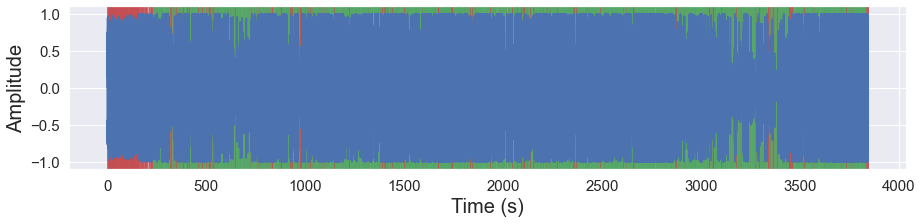

In [77]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

In [78]:
result_diarization_conformer = malaya_speech.diarization.speaker_similarity(grouped_vad, model_conformer)
result_diarization_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x24dc43ca590>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24dd1bc54b0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24dd1bc5510>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24dd1bc5570>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24dd1bc55d0>, 'not a speaker')]

In [91]:
result_diarization_ap_conformer = malaya_speech.diarization.affinity_propagation(grouped_vad, model_conformer)
result_diarization_ap_conformer[:5]

AttributeError: module 'malaya_speech.diarization' has no attribute 'affinity_propagation'

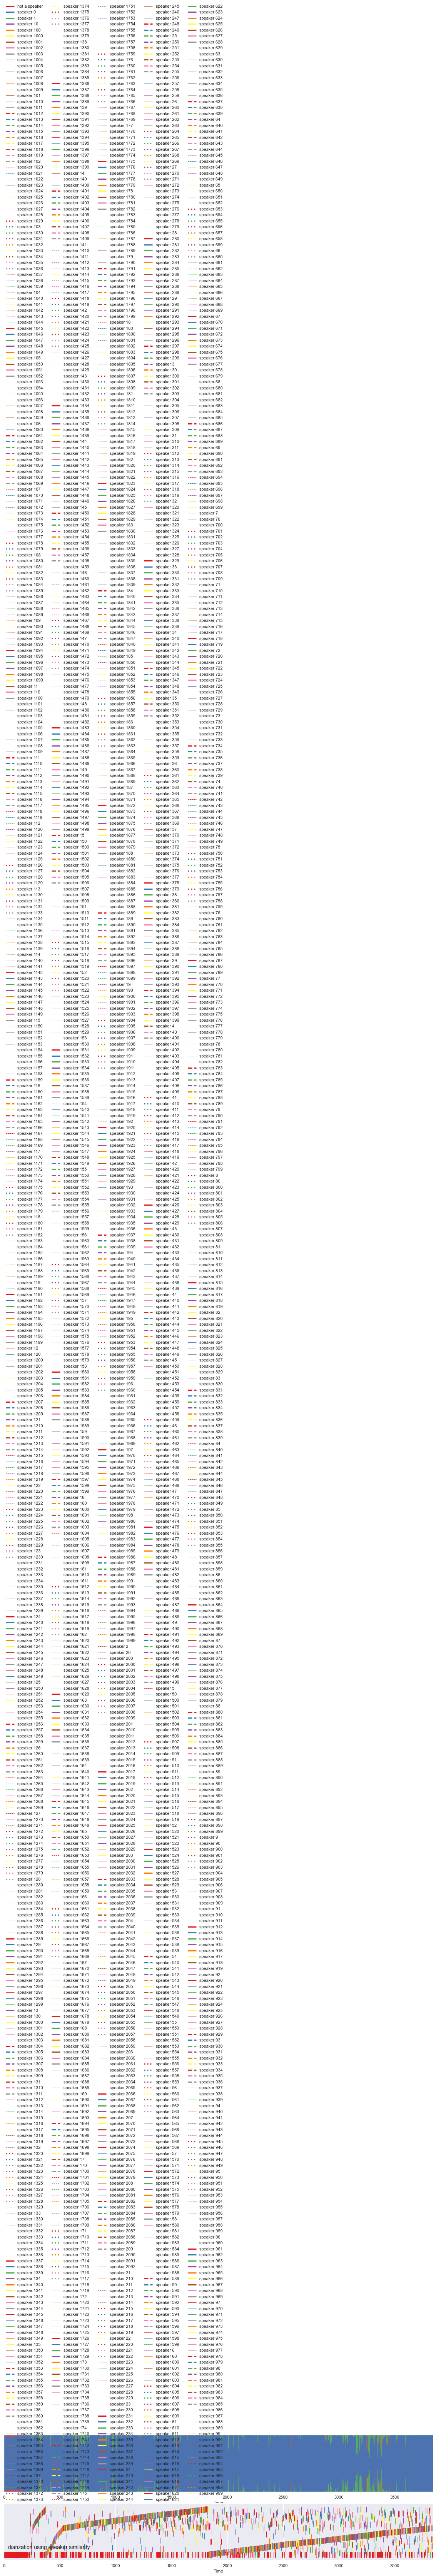

In [79]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_conformer,
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

In [89]:
def n_clustering(
    vad_results,
    speaker_vector,
    model,
    return_embedding=False
    ):
    """
    Speaker diarization using any clustering model.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    model: callable
        Prefer any sklearn unsupervised clustering model.
        Required `fit_predict` or `apply` method.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default='cosine')
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """

In [90]:
from sklearn.cluster import KMeans, SpectralClustering
n_speakers = 8
spectralclustering = SpectralClustering(n_clusters = n_speakers)
result_diarization_spectralclustering_conformer = malaya_speech.diarization.n_clustering(grouped_vad, model_conformer,
                                                                          model = spectralclustering,
                                                                          norm_function = lambda x: x)
result_diarization_spectralclustering_conformer[:5]


AttributeError: module 'malaya_speech.diarization' has no attribute 'n_clustering'

In [92]:
from resemblyzer import preprocess_wav, VoiceEncoder
from pathlib import Path

#give the file path to your audio file
audio_file_path = 'my_recording.wav'
wav_fpath = Path(audio)

wav = preprocess_wav(wav_fpath)
encoder = VoiceEncoder("cpu")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
print(cont_embeds.shape)

Loaded the voice encoder model on cpu in 0.01 seconds.
(55258, 256)


In [121]:
from spectralcluster import SpectralClusterer
from sklearn.cluster import SpectralClustering

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=100)

labels = clusterer.predict(cont_embeds)

KeyboardInterrupt: 

In [118]:
clustering = 

array([0], dtype=int64)

In [115]:
def create_labelling(labels,wav_splits):
    #from resemblyzer import sampling_rate
    times = [((s.start + s.stop) / 2)  / 0.2 for s in wav_splits]
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),start_time,time]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),start_time,time]
            labelling.append(tuple(temp))

    return labelling
  
labelling = create_labelling(labels,wav_splits)
labelling

[('0', 0, 265297600.0)]